# Small crystalline dataset

> Georgios Varnavides | Oct 21 2025  
>
> Sample: thin strontium titanate (STO)  
> Sampling conditions: Nyquist  
> Imaging conditions: 20 mrad, in-focus, defocus, coma, defocus + coma  

In [1]:
import abtem
import ase
import numpy as np
import matplotlib.pyplot as plt

## STO Unitcell

We'll make an ASE Atoms object using Materials Project entry [mp-5229](https://next-gen.materialsproject.org/materials/mp-5229). Note this uses Wyckoff Positions and Spacegroups, but you can also export the CIF/POSCAR file if you prefer.

In [2]:
spacegroup = ase.spacegroup.Spacegroup("Pm-3m") # 221
lattice_parameter = 3.91 # Angstroms

wyckoff_symbols = np.array(['Sr', 'Ti', 'O'])
# from Materials Project
scaled_positions, kinds = spacegroup.equivalent_sites(
    scaled_positions=[
        (0, 0, 0),       # Sr at 1a
        (0.5, 0.5, 0.5), # Ti at 1b
        (0.5, 0, 0.5)    # O at 3c (one of the three equivalent positions)
    ]
)

sto_unitcell = ase.Atoms(
    symbols = wyckoff_symbols[kinds],
    scaled_positions = scaled_positions,
    cell=[lattice_parameter, lattice_parameter, lattice_parameter],
    pbc=True
)

## STO Atoms

We'll tile the unitcell 6 times in the in-plane direction, and 3 times along the beam direction.

_Note:_ This is unrealistically thin, and we'll use it to investigate weak-phase imaging techniques. More realistic thicker specimens will be investigated with a different dataset.

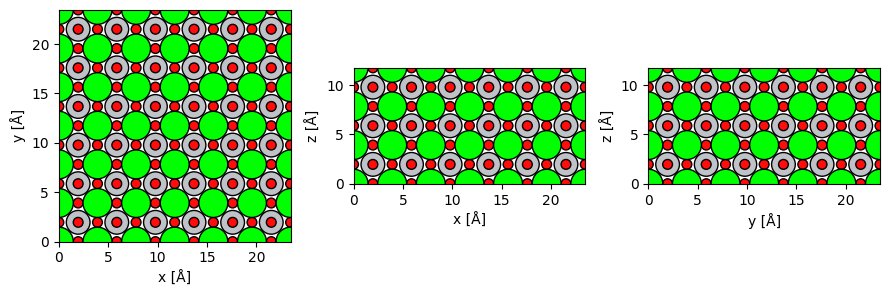

In [3]:
repetitions = (6,6,3)
sto_atoms = sto_unitcell * repetitions

fig, axs = plt.subplots(1,3,figsize=(3*3,3*1))
for ax, plane in zip(axs,['xy','xz','yz']):
    abtem.show_atoms(
        sto_atoms,ax=ax,plane=plane,
        tight_limits=True,
        show_periodic=True,
    )
fig.tight_layout()

## Potential 

We build the numeric representation of the atomic potentials.

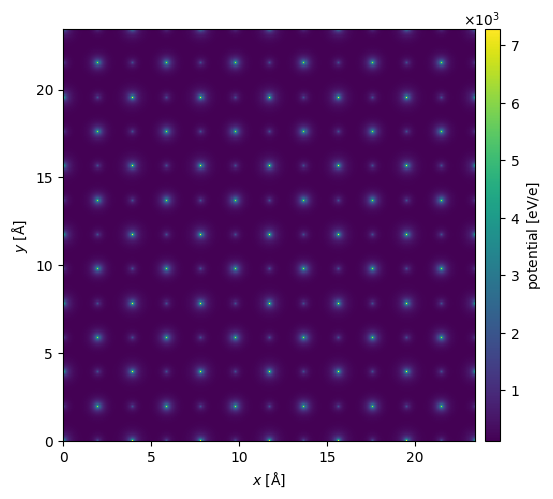

In [4]:
potential = abtem.Potential(
    sto_atoms,
    sampling=lattice_parameter/64,
    slice_thickness= lattice_parameter/2,
).build(
    lazy=False
)

potential.show(
    cbar=True
);

## Probe

We use a converged probe with a few different aberrations.

[########################################] | 100% Completed | 106.57 ms


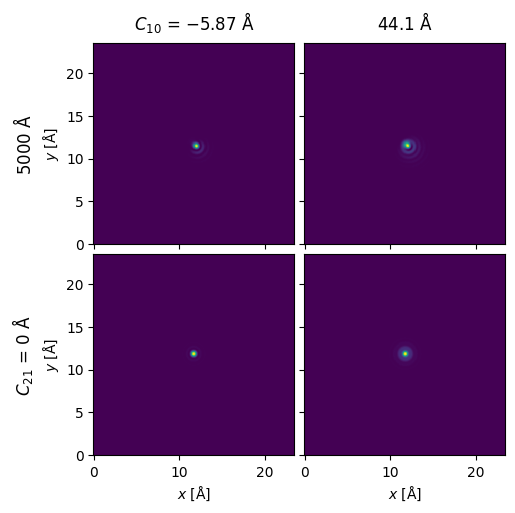

In [6]:
energy = 300e3 # eV
semiangle_cutoff = 20 # mrad

middle_focus_offset = sto_atoms.cell[2,2]/2
defocus_magnitude= 50
coma_magnitude = 5000

aberrations = {
    "C10":(
        0-middle_focus_offset,
        defocus_magnitude-middle_focus_offset
    ),
    "C21":(0,coma_magnitude),
    "phi21":-0.8,
}

# 2x2 probes ensemble
probes = abtem.Probe(
    energy=energy,
    semiangle_cutoff=semiangle_cutoff,
    aberrations=aberrations,
).match_grid(
    potential
)

probes.show(
    explode=True
)

## Simulations

In [7]:
grid_scan_Nyquist = abtem.GridScan(
    end = (lattice_parameter,lattice_parameter),
    gpts=(32,32)
)

detector = abtem.PixelatedDetector(
    max_angle=None
)

In [8]:
measurements = probes.scan(
    potential,
    grid_scan_Nyquist,
    detector
).compute(
).crop(
    gpts=(192,192)
)

[########################################] | 100% Completed | 25.38 s


## Save Multidimensional Dataset
Temporary fix, until abTEM supports zarr>3.

In [9]:
import quantem as em

sampling = [
    aberrations["C10"][-1] + middle_focus_offset,
    aberrations["C21"][-1],
    grid_scan_Nyquist.sampling[0],
    grid_scan_Nyquist.sampling[1],
    measurements.angular_sampling[0],
    measurements.angular_sampling[1],
]

units = ["A","A","A","A","mrad","mrad"]

dataset = em.core.datastructures.Dataset.from_array(
    measurements.to_cpu().array,
    sampling=sampling,
    units=units,
)

dataset.save("../data/STO_20mrad_C10_C21_Nyquist.zip",mode='o')